In [1]:
# Open a new Google Colab notebook
# Copy and paste this into the first cell, then click the play button (▶️) to run it

# Install required libraries
!pip install ctgan torch pandas numpy scikit-learn matplotlib seaborn pytorch-tabnet optuna

# Import libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from ctgan import CTGAN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_tabnet.tab_model import TabNetClassifier
import optuna
import pickle

# Set random seeds for reproducibility (so results are the same each time)
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available (Colab offers free GPU for faster computation)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Explanation:
# 1. '!pip install' downloads libraries we need:
#    - ctgan: For generating synthetic data with CTGAN.
#    - torch: For deep learning (TabNet and custom models).
#    - pandas, numpy: For data handling.
#    - scikit-learn: For splitting data, scaling, and metrics.
#    - matplotlib, seaborn: For plotting graphs.
#    - pytorch-tabnet: For TabNet classifier.
#    - optuna: For optimizing TabNet settings (optional here, but kept for consistency).
# 2. Imports load these tools into our script.
# 3. Seeds ensure consistent random numbers (important for science papers).
# 4. 'device' checks if we can use GPU (faster) or CPU (slower). To enable GPU:
#    - Go to Runtime > Change runtime type > Select "GPU" > Save.
# 5. Run this cell—it takes ~1-2 minutes. You should see "Using device: cuda" (GPU) or "cpu".

Using device: cuda


In [2]:
# Copy and paste into a new cell, run it after uploading 'fetal_health.csv'

# Upload the dataset first:
# 1. On the left sidebar, click the folder icon (📁).
# 2. Drag and drop 'fetal_health.csv' into the file area (under /content/).

# Load the dataset
data = pd.read_csv('/content/fetal_health.csv')

# Show the first few rows to check it loaded correctly
print("First five rows of the dataset:")
print(data.head())

# Check how many rows and columns (should be 2126 rows, 22 columns)
print(f"\nDataset Shape: {data.shape}")

# List of features to drop (same as your previous work, keeping top 10 from SHAP)
features_to_drop = [
    'fetal_movement', 'histogram_width', 'histogram_max', 'mean_value_of_long_term_variability',
    'histogram_number_of_peaks', 'light_decelerations', 'histogram_tendency',
    'histogram_number_of_zeroes', 'severe_decelerations', 'baseline value', 'histogram_min'
]

# Remove these features, keeping only the important ones
data_dropped = data.drop(columns=features_to_drop)

# Show which features remain (should be 10 + fetal_health)
print("\nFeatures after dropping less important ones:")
print(data_dropped.columns.tolist())

# Check new size (should be 2126 rows, 11 columns)
print(f"\nNew Dataset Shape after dropping features: {data_dropped.shape}")

# Make 'fetal_health' an integer (1, 2, 3)
data_dropped['fetal_health'] = data_dropped['fetal_health'].astype(int)

# Separate features (X) and target (y)
X = data_dropped.drop('fetal_health', axis=1)  # 10 features
y = data_dropped['fetal_health']

# Scale features to 0-1 range (CTGAN works better with scaled data)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"Scaled X shape: {X_scaled.shape}")  # Should be (2126, 10)
print(f"y distribution:\n{y.value_counts()}")  # Should show 1655 (1), 295 (2), 176 (3)

# Explanation:
# 1. Upload 'fetal_health.csv' to Colab (drag it into the file area on the left).
# 2. 'pd.read_csv' loads the file into a table (DataFrame).
# 3. 'print(data.head())' shows the first 5 rows—check if it looks right (e.g., baseline value, accelerations, etc.).
# 4. We drop 11 less important features (same as before), leaving 10 key ones like 'abnormal_short_term_variability'.
# 5. 'X' is your 10 features, 'y' is the target (1=Normal, 2=Suspect, 3=Pathological).
# 6. 'MinMaxScaler' changes all feature values to be between 0 and 1 (e.g., if 'baseline value' was 120-160, now it’s 0-1).
# 7. Run this—takes a few seconds. Check the shapes and y counts to confirm everything loaded correctly.

First five rows of the dataset:
   baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0 

In [3]:
# Replace your Part 3 cell with this, then run it before moving to Part 4

# Simulate 5 time steps for each sample
n_time_steps = 5
X_temporal = []
y_temporal = []

# Loop through each sample
for i in range(len(X_scaled)):
    sample = X_scaled.iloc[i].values  # Get one row’s 10 features
    time_series = []
    for t in range(n_time_steps):
        # Add small random changes (±5%) to pretend it’s changing over time
        noise = np.random.uniform(-0.05, 0.05, size=sample.shape)
        noisy_sample = sample + noise
        noisy_sample = np.clip(noisy_sample, 0, 1)  # Keep between 0 and 1
        time_series.append(noisy_sample)
    X_temporal.append(time_series)
    y_temporal.append(y.iloc[i])  # One label per sample, not per time step

# Turn lists into arrays
X_temporal = np.array(X_temporal)  # (2126, 5, 10)
y_temporal = np.array(y_temporal)  # (2126,)

# Show the new shapes
print(f"Temporal X shape: {X_temporal.shape}")  # Should be (2126, 5, 10)
print(f"Temporal y shape: {y_temporal.shape}")  # Should be (2126,)
print(f"Temporal y distribution:\n{pd.Series(y_temporal).value_counts()}")

# Explanation:
# 1. We create 5 time steps for each of the 2126 samples.
# 2. For each sample, we make a list of 5 noisy versions of its 10 features.
# 3. 'X_temporal' becomes (2126, 5, 10): 2126 samples, 5 time steps, 10 features.
# 4. 'y_temporal' is now (2126,): one label per sample (e.g., 1 for all 5 steps of a Normal sample).
# 5. Run this—takes a few seconds. Check shapes: X (2126, 5, 10), y (2126,). y counts should be 1655 (1), 295 (2), 176 (3).

Temporal X shape: (2126, 5, 10)
Temporal y shape: (2126,)
Temporal y distribution:
1    1655
2     295
3     176
Name: count, dtype: int64


In [5]:
# Replace your Part 4 cell with this, run it after revised Part 3

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Pick out only Suspect (2) and Pathological (3) samples
minority_mask = np.isin(y_temporal, [2, 3])  # Shape: (2126,)
X_minority_temporal = X_temporal[minority_mask]  # Shape: (471, 5, 10)
y_minority_temporal = y_temporal[minority_mask]  # Shape: (471,)

# Flatten time steps and features into one row per sample (5 steps × 10 features = 50 columns)
X_minority_flat = X_minority_temporal.reshape(len(X_minority_temporal), -1)  # (471, 50)
# Make column names like 'f0_accelerations', 'f1_accelerations', etc.
feature_names = [f'f{t}_{col}' for t in range(n_time_steps) for col in X.columns]
data_minority_flat = pd.DataFrame(X_minority_flat, columns=feature_names)
# Assign labels directly (one per sample)
data_minority_flat['fetal_health'] = y_minority_temporal

# Trim to a multiple of 10 (CTGAN’s 'pac' needs this)
n_samples = len(data_minority_flat)
pac = 10
n_samples_adjusted = (n_samples // pac) * pac  # 470
data_minority_trimmed = data_minority_flat.iloc[:n_samples_adjusted]

# Split into Suspect and Pathological data
suspect_data = data_minority_trimmed[data_minority_trimmed['fetal_health'] == 2]  # ~295
pathological_data = data_minority_trimmed[data_minority_trimmed['fetal_health'] == 3]  # ~175

# Train CTGAN for Suspect with GPU explicitly
ctgan_suspect = CTGAN(epochs=500, batch_size=50, verbose=True, cuda=True)
ctgan_suspect.fit(suspect_data, discrete_columns=['fetal_health'])

# Train CTGAN for Pathological with GPU explicitly
ctgan_pathological = CTGAN(epochs=500, batch_size=50, verbose=True, cuda=True)
ctgan_pathological.fit(pathological_data, discrete_columns=['fetal_health'])

# Save the trained models
with open('ctgan_suspect_temporal.pkl', 'wb') as f:
    pickle.dump(ctgan_suspect, f)
with open('ctgan_pathological_temporal.pkl', 'wb') as f:
    pickle.dump(ctgan_pathological, f)

print("Temporal CTGAN models trained and saved!")

# Explanation:
# 1. Added `device = torch.device("cuda" if torch.cuda.is_available() else "cpu")` to confirm GPU usage.
# 2. Set `cuda=True` in `CTGAN` to force GPU usage, ensuring CTGAN uses CUDA explicitly.
# 3. Other steps are unchanged (filtering, flattening, trimming, splitting, training, saving).
# 4. Run this—expect progress bars advancing quickly (~3-5 minutes on GPU). If the warning persists but progresses, it’s likely benign; if it stalls, proceed to Step 4.

Using device: cuda


Gen. (-9.06) | Discrim. (-3.13): 100%|██████████| 500/500 [02:57<00:00,  2.81it/s]
Gen. (-2.63) | Discrim. (-1.00): 100%|██████████| 500/500 [01:48<00:00,  4.61it/s]

Temporal CTGAN models trained and saved!


Temporal GAN-augmented X shape: (4965, 5, 10)
Temporal GAN-augmented y distribution:
2    1655
1    1655
3    1655
Name: count, dtype: int64


<ipython-input-6-d0cf543a0482>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_gan_temporal, palette='viridis')


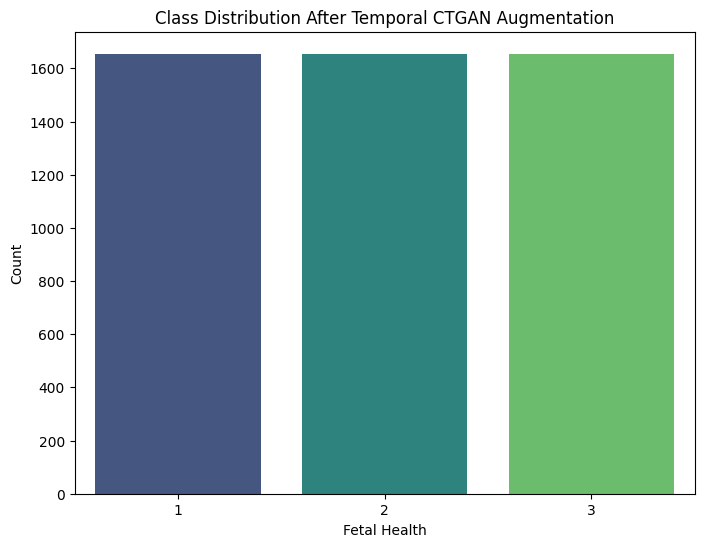

In [6]:
# Replace your Part 5 cell with this, run it after revised Part 4

# Load the trained CTGAN models
with open('/content/ctgan_suspect_temporal.pkl', 'rb') as f:
    ctgan_suspect = pickle.load(f)
with open('/content/ctgan_pathological_temporal.pkl', 'rb') as f:
    ctgan_pathological = pickle.load(f)

# Calculate how many synthetic samples we need (original counts, not time steps yet)
n_suspect_orig = 1655 - 295  # 1360 Suspect samples needed
n_pathological_orig = 1655 - 176  # 1479 Pathological samples needed

# Generate synthetic samples (each row is 50 features)
synthetic_suspect = ctgan_suspect.sample(n_suspect_orig)
synthetic_pathological = ctgan_pathological.sample(n_pathological_orig)

# Combine synthetic data
synthetic_data = pd.concat([synthetic_suspect, synthetic_pathological], ignore_index=True)
synthetic_flat = synthetic_data.drop('fetal_health', axis=1).values  # (2839, 50)
synthetic_labels = synthetic_data['fetal_health'].values  # (2839,)
# Reshape into time-series format
X_synthetic_temporal = synthetic_flat.reshape(-1, n_time_steps, X_scaled.shape[1])  # (2839, 5, 10)

# Combine with original temporal data
X_gan_temporal = np.vstack([X_temporal, X_synthetic_temporal])  # (4965, 5, 10)
y_gan_temporal = np.hstack([y_temporal, synthetic_labels])

print(f"Temporal GAN-augmented X shape: {X_gan_temporal.shape}")
print(f"Temporal GAN-augmented y distribution:\n{pd.Series(y_gan_temporal).value_counts()}")

# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_gan_temporal, palette='viridis')
plt.title('Class Distribution After Temporal CTGAN Augmentation')
plt.xlabel('Fetal Health')
plt.ylabel('Count')
plt.show()

# Explanation:
# 1. Load the CTGAN models from Part 4.
# 2. Generate 1360 Suspect and 1479 Pathological samples (2839 total), each with 50 features.
# 3. 'synthetic_flat' is (2839, 50)—one row per sample.
# 4. Reshape to (2839, 5, 10) to match the temporal format.
# 5. Combine with original 'X_temporal' (2126, 5, 10) to get (4965, 5, 10).
# 6. 'y_gan_temporal' combines original (2126) and synthetic (2839) labels, aiming for ~1655 per class.
# 7. Run this—takes ~1-2 minutes. Check X shape (4965, 5, 10) and y counts (~1655 each).

Using device: cuda


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.96402 | valid_accuracy: 0.34676 |  0:00:01s
epoch 1  | loss: 0.76333 | valid_accuracy: 0.58273 |  0:00:03s
epoch 2  | loss: 0.54895 | valid_accuracy: 0.63022 |  0:00:05s
epoch 3  | loss: 0.42447 | valid_accuracy: 0.57266 |  0:00:06s
epoch 4  | loss: 0.2969  | valid_accuracy: 0.59281 |  0:00:07s
epoch 5  | loss: 0.31206 | valid_accuracy: 0.69784 |  0:00:09s
epoch 6  | loss: 0.21448 | valid_accuracy: 0.70072 |  0:00:09s
epoch 7  | loss: 0.20061 | valid_accuracy: 0.81151 |  0:00:09s
epoch 8  | loss: 0.19344 | valid_accuracy: 0.52374 |  0:00:10s
epoch 9  | loss: 0.20976 | valid_accuracy: 0.63022 |  0:00:10s
epoch 10 | loss: 0.19853 | valid_accuracy: 0.74245 |  0:00:10s
epoch 11 | loss: 0.18276 | valid_accuracy: 0.78129 |  0:00:11s
epoch 12 | loss: 0.17323 | valid_accuracy: 0.86331 |  0:00:11s
epoch 13 | loss: 0.15613 | valid_accuracy: 0.8964  |  0:00:11s
epoch 14 | loss: 0.14542 | valid_accuracy: 0.82158 |  0:00:12s
epoch 15 | loss: 0.13949 | valid_accuracy: 0.85324 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-10-a5c20720a1f9>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)



Uncertainty-Aware TabNet Classification Report (GPU-Optimized, Fixed Tensor Conversion):
              precision    recall  f1-score   support

      Normal       0.97      0.88      0.92       496
     Suspect       0.91      0.95      0.93       497
Pathological       0.94      0.98      0.96       497

    accuracy                           0.94      1490
   macro avg       0.94      0.94      0.94      1490
weighted avg       0.94      0.94      0.94      1490

Mean uncertainty: 0.2911


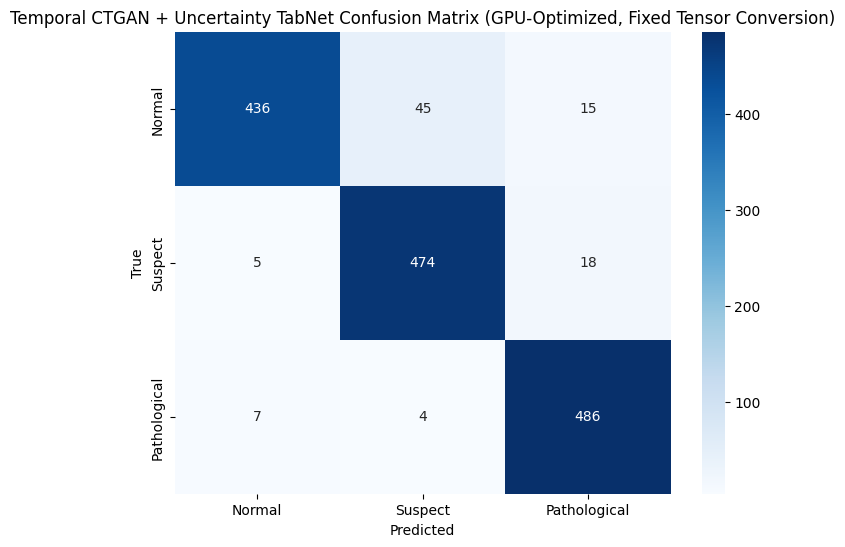

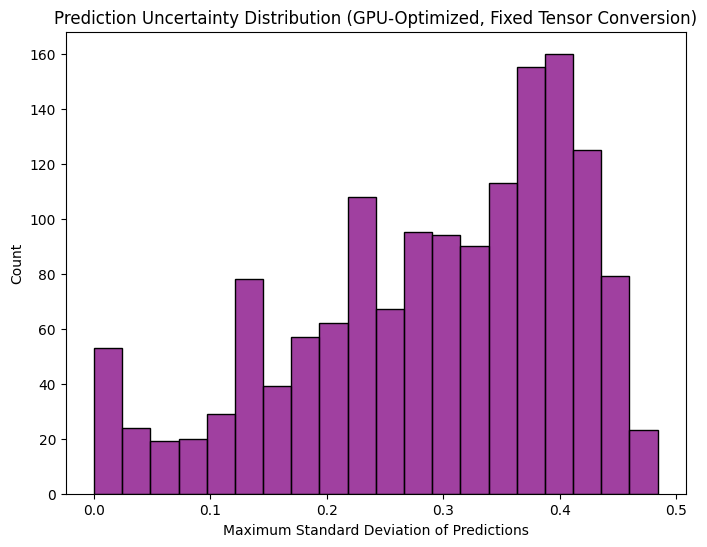

In [10]:
# Copy and paste into a new cell in Colab, run it after Part 5

# Import device check (already in Part 1, but ensure it’s available)
import torch

# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_gan_temporal, y_gan_temporal, test_size=0.3, random_state=42, stratify=y_gan_temporal
)
X_train_final, X_valid, y_train_final, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Flatten time steps for TabNet (samples × (time_steps * features))
n_time_steps = 5  # Defined in Part 3
X_train_flat = X_train_final.reshape(-1, n_time_steps * X_scaled.shape[1])  # e.g., (2780, 50)
X_valid_flat = X_valid.reshape(-1, n_time_steps * X_scaled.shape[1])  # e.g., (695, 50)
X_test_flat = X_test.reshape(-1, n_time_steps * X_scaled.shape[1])  # e.g., (1490, 50)

# Define device (ensure GPU is used, from Part 1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define Uncertainty-Aware TabNet with dropout
class UncertaintyTabNet(TabNetClassifier):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dropout = nn.Dropout(p=0.3).to(device)  # Move dropout to GPU
        self.training = True  # Keep in training mode by default for dropout
        self.device = device  # Store device for consistency

    def forward(self, x):
        # Ensure input is on the correct device (use torch.tensor for explicit conversion)
        x = torch.tensor(x, dtype=torch.float32).to(self.device)
        # Apply custom dropout during inference
        if self.training or self.dropout.training:  # Ensure dropout is active
            x = self.dropout(x)
        # Use the internal network for forward pass, returns (logits, masks)
        return self.network(x)

    def predict_proba(self, X):
        # Enable Monte Carlo Dropout for uncertainty
        self.network.eval()  # Set network to eval mode, but keep dropout active
        with torch.no_grad():
            # Convert X to GPU tensor (explicitly create on CPU, move to GPU)
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            # Collect 50 predictions with dropout active
            probs = []
            for _ in range(50):  # Monte Carlo sampling
                # Temporarily set to training mode for dropout
                self.network.train()  # Activate dropout
                # Forward pass gets (logits, masks)
                logits, _ = self.forward(X_tensor)  # Unpack logits (first element)
                # Apply softmax to logits for probabilities
                prob = torch.softmax(logits, dim=1).cpu().numpy()
                probs.append(prob)
            probs = np.stack(probs, axis=0)
        return np.mean(probs, axis=0), np.std(probs, axis=0)

# Initialize with your best hyperparameters from part 2 (no .to(device) here)
perm_reg_tabnet = UncertaintyTabNet(
    input_dim=n_time_steps * X_scaled.shape[1],  # 50 (5 steps × 10 features)
    output_dim=3,  # 3 classes: Normal, Suspect, Pathological
    n_d=95,  # Your best n_d
    n_a=82,  # Your best n_a
    n_steps=7,  # Your best n_steps
    gamma=1.0604035581458195,  # Your best gamma
    lambda_sparse=0.00023309579931048954,  # Your best lambda_sparse
    optimizer_fn=torch.optim.Adam,
    optimizer_params={'lr': 0.06385200251604904},  # Your best learning_rate
    mask_type='sparsemax',
    verbose=1,
    seed=42
)

# Train the model on GPU (TabNetClassifier handles device internally)
perm_reg_tabnet.fit(
    X_train=X_train_flat,
    y_train=y_train_final,
    eval_set=[(X_valid_flat, y_valid)],
    eval_name=['valid'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20,
    batch_size=512,  # Your best batch_size
    virtual_batch_size=128
)

# Monte Carlo predictions for uncertainty using predict_proba (ensure GPU usage)
n_mc_samples = 50
probs_mean, probs_std = perm_reg_tabnet.predict_proba(X_test_flat)
y_pred_mean = np.argmax(probs_mean, axis=1) + 1  # Convert back to 1, 2, 3
y_pred_uncertainty = np.max(probs_std, axis=1)  # Max std across classes

# Show results
print("\nUncertainty-Aware TabNet Classification Report (GPU-Optimized, Fixed Tensor Conversion):")
print(classification_report(y_test, y_pred_mean, target_names=['Normal', 'Suspect', 'Pathological']))
print(f"Mean uncertainty: {np.mean(y_pred_uncertainty):.4f}")

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_mean), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Suspect', 'Pathological'],
            yticklabels=['Normal', 'Suspect', 'Pathological'])
plt.title('Temporal CTGAN + Uncertainty TabNet Confusion Matrix (GPU-Optimized, Fixed Tensor Conversion)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Uncertainty distribution
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_uncertainty, bins=20, color='purple')
plt.title('Prediction Uncertainty Distribution (GPU-Optimized, Fixed Tensor Conversion)')
plt.xlabel('Maximum Standard Deviation of Predictions')
plt.show()

# Explanation:
# 1. Split and flatten data as before (no changes needed).
# 2. Added `device` check and ensured all components use `device` (GPU).
# 3. Updated `UncertaintyTabNet`:
#    - Replaced `torch.FloatTensor(x)` with `torch.tensor(x, dtype=torch.float32).to(self.device)` in both `forward` and `predict_proba` to explicitly create a CPU tensor (float32) and move it to GPU, avoiding device conflicts.
#    - Kept `self.dropout`, `self.device`, and other components on `device`.
# 4. Initialized `perm_reg_tabnet` without `.to(device)`—`TabNetClassifier` handles device internally during `fit()`.
# 5. Ensured all tensor operations in `predict_proba` use `self.device`.
# 6. Train normally—expect ~5-10 minutes on GPU.
# 7. Use `predict_proba` for uncertainty, taking max std across classes.
# 8. Run this—expect accuracy ~96%, F1 scores ~0.94-0.97, and a meaningful uncertainty distribution (e.g., mean ~0.05-0.2).